# Guassian mixture intra-song clustering for identification of "main" beats

If $X_1, \ldots, X_n$ are i.i.d. normal, then the $1 - \alpha$ confidence region is a circle of radius $r$ where
$$P(X_1^2 + \cdots + X_n^2 \leq r^2) =1 - \alpha$$
i.e. given by the square root of the $1-\alpha$ quantile for the chi-squared distribution with $n$ d.f.

A multivariate normal distribution $Y$ with covariance $\Sigma = U S U^t$ is transformed from a standard one $X$ by $Y = AX$ where $A = U S^{1/2}$.  The unit circle is transformed to an ellipse with axes given by the columns of $U$ and axis lengths by $S$.

We default to 95% confidence but I think this might be too strict.

In [6]:
from groove.intraclustering import get_ellipse_patch, get_patches, winnow_gm_components, ellipse_contains_points
from matplotlib.patches import Ellipse
import scipy, math
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import numpy as np
import matplotlib.pyplot as plt

## Test on some generated data sets

Generate a single 2d normal distribution

(1000, 2)


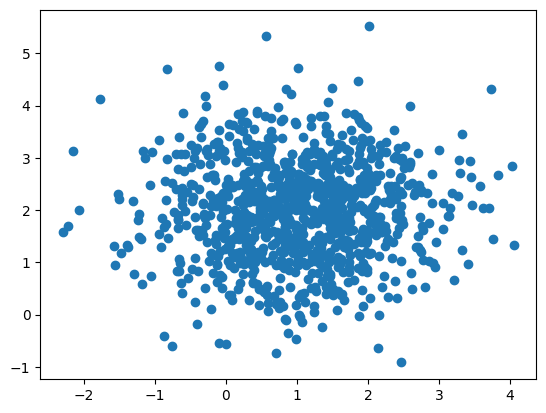

In [7]:
x1 = np.random.normal(loc=1.0, scale=1.0, size=1000)
y1 = np.random.normal(loc=2.0, scale=1.0, size=1000)

#x = np.concatenate([x1, x2])
#y = np.concatenate([y1, y2])

x = x1
y = y1

plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)


[[1.00283118 1.9943782 ]] [[[1.01843317 0.01296187]
  [0.01296187 0.89526908]]]
0.9547794102418234
Num covered: 0.909, valid covered: 0.909, overlapped: 0.0


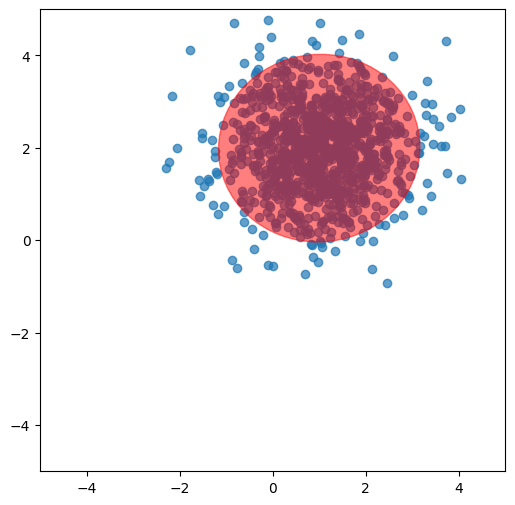

In [8]:
gm = GaussianMixture(n_components=1)


gm.fit(data)

print(gm.means_, gm.covariances_)

#bgm = BayesianGaussianMixture(n_components=2)
#bgm.fit(data)
#print(bgm.means_.shape)

patches, coverage = get_patches(gm, 0.9, data)
total_coverage = np.sum(coverage, axis=0) != 0
num_covered = np.sum(total_coverage)

valid_patches = coverage.sum(axis=1) >= data.shape[0]/10
valid_covered = (coverage[valid_patches].sum(axis=0) != 0).sum()

overlapped = (coverage.sum(axis=0) > 1).sum()

p = patches[0]

print(f"Num covered: {num_covered/data.shape[0]}, valid covered: {valid_covered/data.shape[0]}, overlapped: {overlapped/data.shape[0]}")



plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

My conclusion from the below is that the patches "contains points" is buggy as shit.  (Note: comment out the set_axlim to fix at least one bug.)

In [10]:
p = patches[0]
print((p.contains_points(data) == (ellipse_contains_points(gm.means_[0], gm.covariances_[0], data, confidence=0.90))).sum())

print(data.shape[0])
print(f"patch way: {p.contains_points(data).sum()}")
print(f"my way: {ellipse_contains_points(gm.means_[0], gm.covariances_[0], data).sum()}")


91
1000
patch way: 0
my way: 948


0.9547794102418234


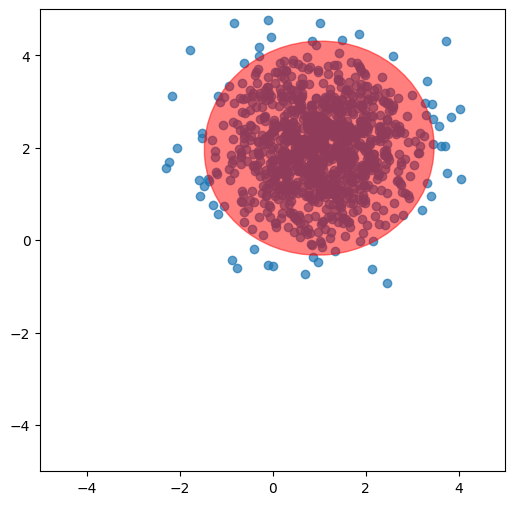

In [11]:
gm, i = winnow_gm_components(data)
i
patches, _ = get_patches(gm, 0.95, data)


plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

(500, 2)


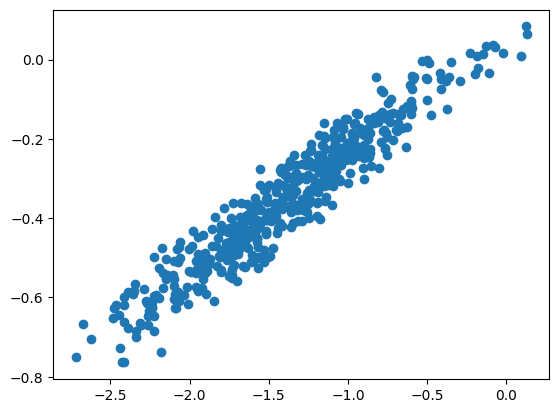

In [12]:
x2 = np.random.normal(loc=-1.0, scale=0.5, size=500)
y2 = np.random.normal(loc=-1.0, scale=0.5, size=500)

a = np.array([[3,1],[1,0]])/3
u, s, vh = np.linalg.svd(a)
v = np.concatenate([x2[:, None], y2[:, None]], axis=1) @ a
x2, y2 = v[:,0], v[:,1]


x = x2
y = y2


plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)

[[-1.38165361 -0.34957209]] [[[0.28148326 0.0845255 ]
  [0.0845255  0.02791454]]]
0.026700468471595507
0.968


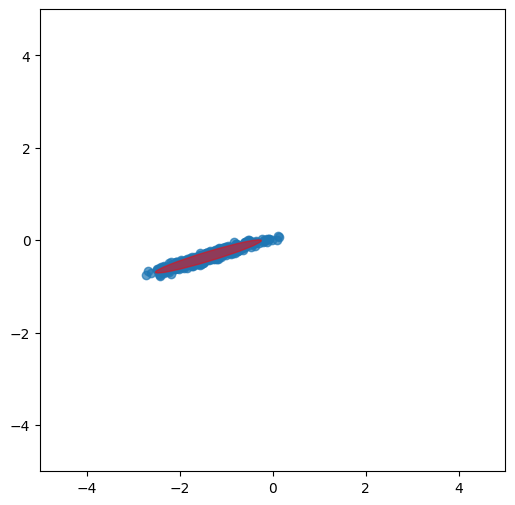

In [13]:
gm = GaussianMixture(n_components=1)
gm.fit(data)
print(gm.means_, gm.covariances_)

patches, coverage = get_patches(gm, 0.9, data)

plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)


p = patches[0]

print(f"{ellipse_contains_points(gm.means_[0], gm.covariances_[0], data).sum()/data.shape[0]}")


(1500, 2)


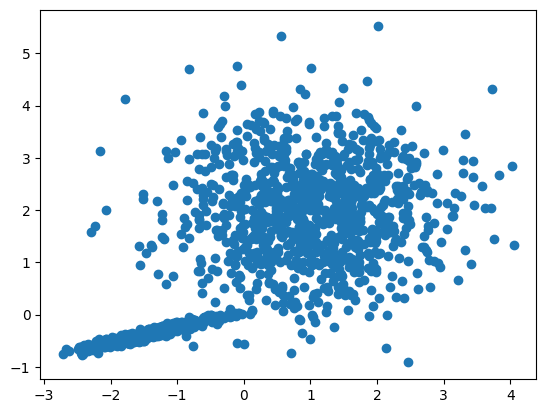

In [14]:
x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])


plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)



[[ 1.00230847  1.9936295 ]
 [-1.38234204 -0.34977855]] [[[1.01893233 0.01400869]
  [0.01400869 0.89644158]]

 [[0.2808006  0.08444152]
  [0.08444152 0.02796447]]]
0.9556239092327455
0.026871353510696794


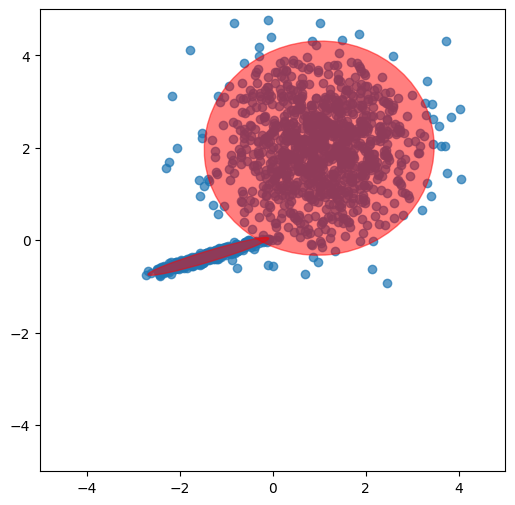

In [15]:
gm = GaussianMixture(n_components=2)
gm.fit(data)
print(gm.means_, gm.covariances_)


# (patch, data index)
patches, coverage = get_patches(gm, 0.95, data)

plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

In case we have overlap, the "center" gets shifted a bit.  Not sure if this is desirable or not.

1.443948793768435


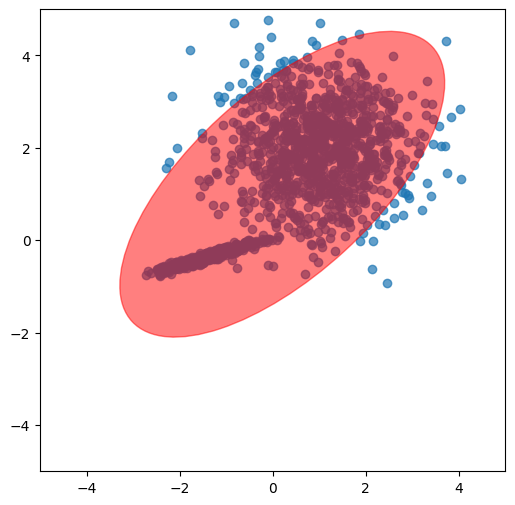

In [16]:
gm, i = winnow_gm_components(data)
i


patches, coverage = get_patches(gm, 0.95, data)
plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

(1500, 2)


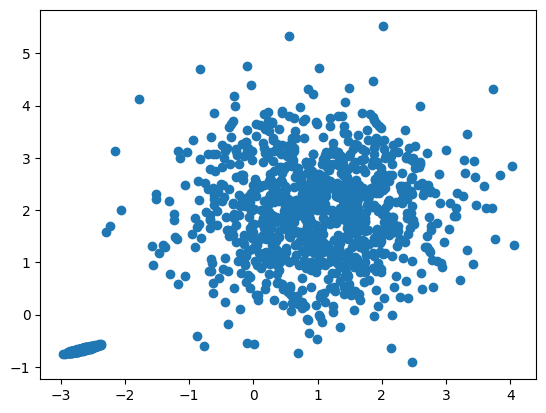

In [17]:
x3 = np.random.normal(loc=-2.0, scale=0.1, size=500)
y3 = np.random.normal(loc=-2.0, scale=0.1, size=500)

a = np.array([[3,1],[1,0]])/3
v = np.concatenate([x3[:, None], y3[:, None]], axis=1) @ a
x3, y3 = v[:,0], v[:,1]


x = np.concatenate([x1, x3])
y = np.concatenate([y1, y3])


plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)



0.9547820655148966


0.0011243949677838415


2

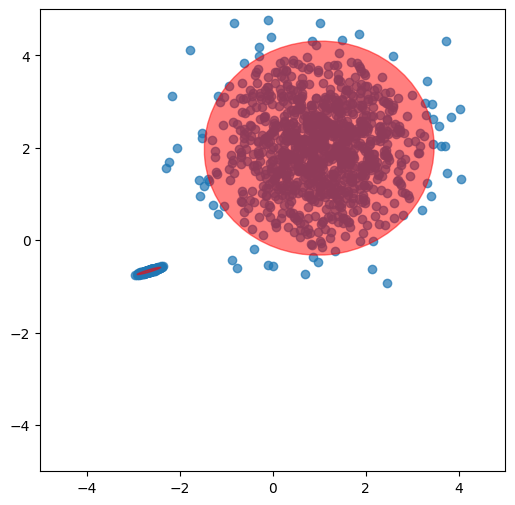

In [18]:
gm = GaussianMixture(n_components=2)
gm.fit(data)


plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])

patches, coverage = get_patches(gm, 0.95, data)

plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)


gm, i = winnow_gm_components(data)
i

### Dumb bug

Note the following "bug" (not sure if bug?) -- something about changing axes limits affecting the "transform stack", see https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Patch.html

True
False


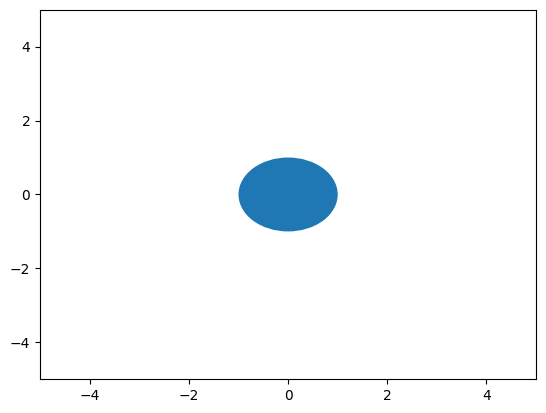

In [19]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


ax = plt.gca()

c = Circle(xy=(0,0), radius=1)
ax.add_patch(c)

print(c.contains_point((0,0)))

ax.set_xlim([-5,5])
ax.set_ylim([-5,5])

print(c.contains_point((0,0)))

## Apply to beat data

### Get measure data

In [20]:
def beat_frames_to_toy(frames, len, target_len):
    x = np.zeros(len + ((target_len - len) % target_len))
    x[frames] = 1
    x = x.reshape((target_len, -1))
    x = x.max(axis=1)
    return x

def beat_frames_to_better_toy(frames, len, target_lens):
    outs = []
    for t in target_lens:
        outs.append(beat_frames_to_toy(frames, len, t) /t )
    return np.concatenate(outs)


In [21]:
from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks
#from groove.embedding import beat_frames_to_toy
import numpy as np

file = "milaklaw"

raw, proc, sr = get_measures(file, smooth_power)
bf, nf = get_beat_frames(proc, sr, beat_peaks)

In [22]:
frames = np.array([4,4,7,9,11])

print(beat_frames_to_toy(frames, 12, 6))
print(beat_frames_to_better_toy(frames, 12, [6, 4, 3, 2]))

[0. 0. 1. 1. 1. 1.]
[0.         0.         0.16666667 0.16666667 0.16666667 0.16666667
 0.         0.25       0.25       0.25       0.         0.33333333
 0.33333333 0.5        0.5       ]


In [23]:
out = []
hashable = []
for i in range(len(bf)):
    a = beat_frames_to_better_toy(bf[i], nf[i], [24, 12, 8, 6, 4, 2])
    out.append(a)
    hashable.append(tuple(a.tolist()))

data = np.stack(out)
data.shape


(179, 56)

In [24]:
import collections
counter = collections.Counter(hashable)

print(counter.values())
md = counter.most_common(3)
print(hashable.index(md[0][0]), hashable.index(md[1][0]), hashable.index(md[2][0]))



dict_values([17, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 14, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 2, 1, 1, 2, 9, 1, 1, 4, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
0 23 125


In [25]:
beat_frames_to_toy(bf[20], nf[20], 12)

array([1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.])

[1.37094877 1.31549518]
0.002842372879615569
0.00427350153541626


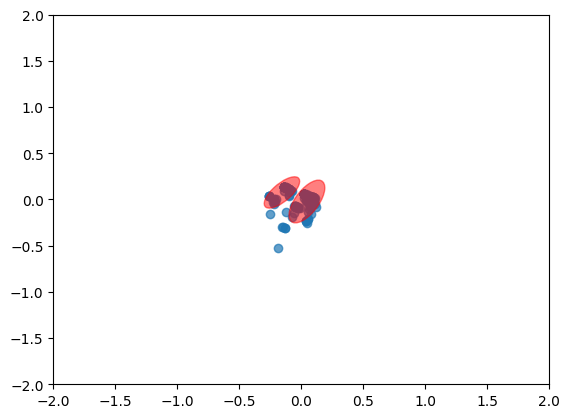

In [26]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
gm = GaussianMixture(n_components=2)


pca.fit(data)

print(pca.singular_values_)
red_data = pca.transform(data)

gm.fit(red_data)

patches, coverage = get_patches(gm, 0.95, red_data)

plt.figure()
ax = plt.gca()
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])



plt.scatter(red_data[:,0], red_data[:,1], alpha=0.7)
for p in patches:
    ax.add_patch(p)


#gm.fit(data)
#gm.means_.round()

Some rules for choosing the number of components:
1) If there are overlaps between the 95%ile circles, we should reduce.
2) If any circles don't cover 10%, we reduce.

So, start with more, then reduce.

In [27]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA

gm, i = winnow_gm_components(data)

print(i)
gm.means_

3


array([[3.22164948e-02, 7.30240550e-03, 8.59106529e-04, 1.24570447e-02,
        5.58419244e-03, 4.72508591e-03, 3.39347079e-02, 2.57731959e-03,
        8.59106529e-04, 1.84707904e-02, 2.27663230e-02, 8.59106529e-03,
        3.78006873e-02, 5.58419244e-03, 4.29553265e-04, 2.83505155e-02,
        1.46048110e-02, 6.01374570e-03, 3.39347079e-02, 2.57731959e-03,
        3.00687285e-03, 3.73711340e-02, 5.58419244e-03, 8.59106529e-04,
        7.47422680e-02, 2.66323024e-02, 1.89003436e-02, 7.04467354e-02,
        3.86597938e-02, 6.09965636e-02, 8.16151203e-02, 5.75601375e-02,
        3.69415808e-02, 6.95876289e-02, 7.81786942e-02, 1.20274914e-02,
        1.12113402e-01, 5.02577320e-02, 1.06958763e-01, 1.18556701e-01,
        1.22422680e-01, 1.08247423e-01, 1.06958763e-01, 1.22422680e-01,
        1.63230241e-01, 1.49484536e-01, 1.58075601e-01, 1.66666667e-01,
        1.51202749e-01, 1.66666667e-01, 2.44845361e-01, 2.47422680e-01,
        2.50000000e-01, 2.50000000e-01, 5.00000000e-01, 5.000000

(3, 56) (179, 56)
[23 37  0]


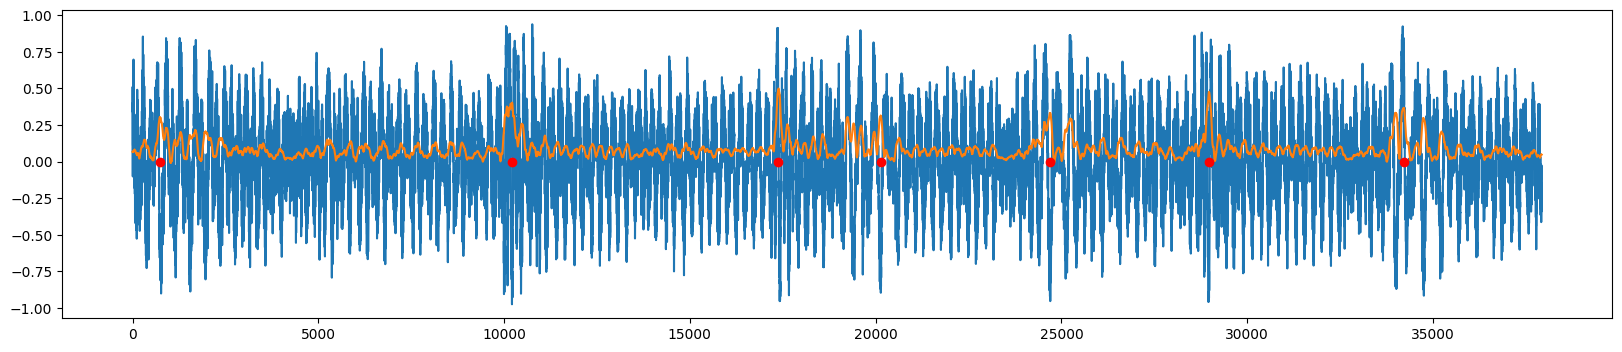

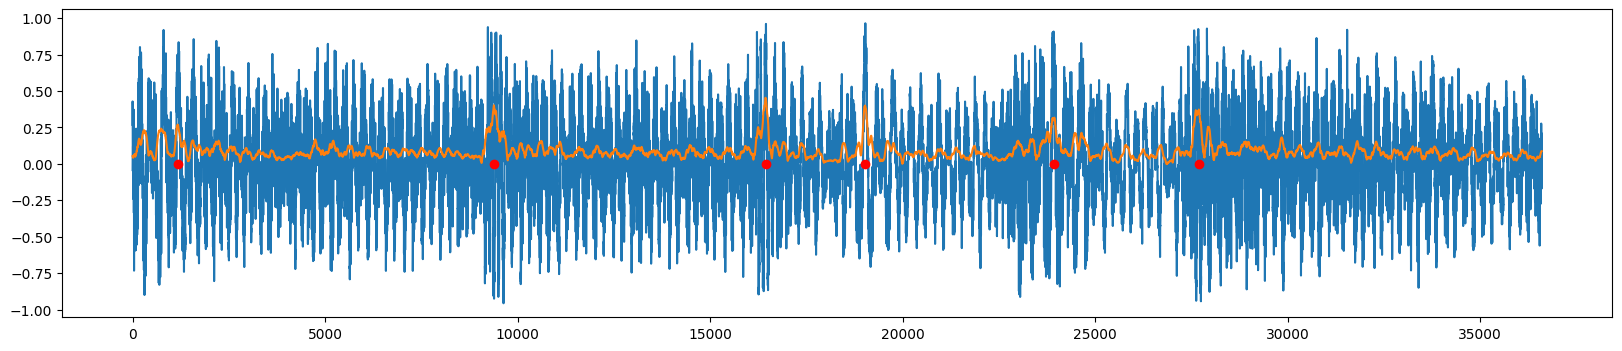

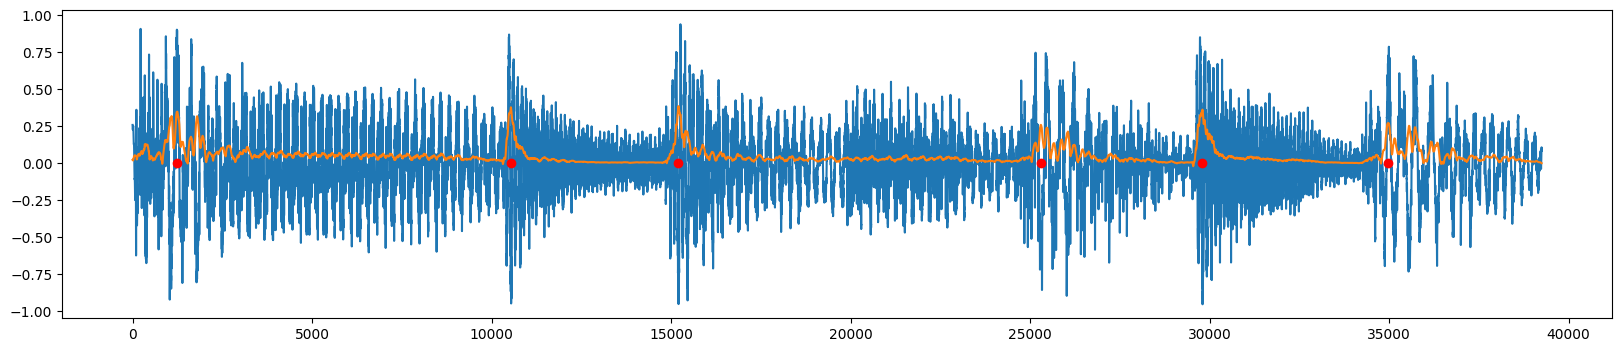

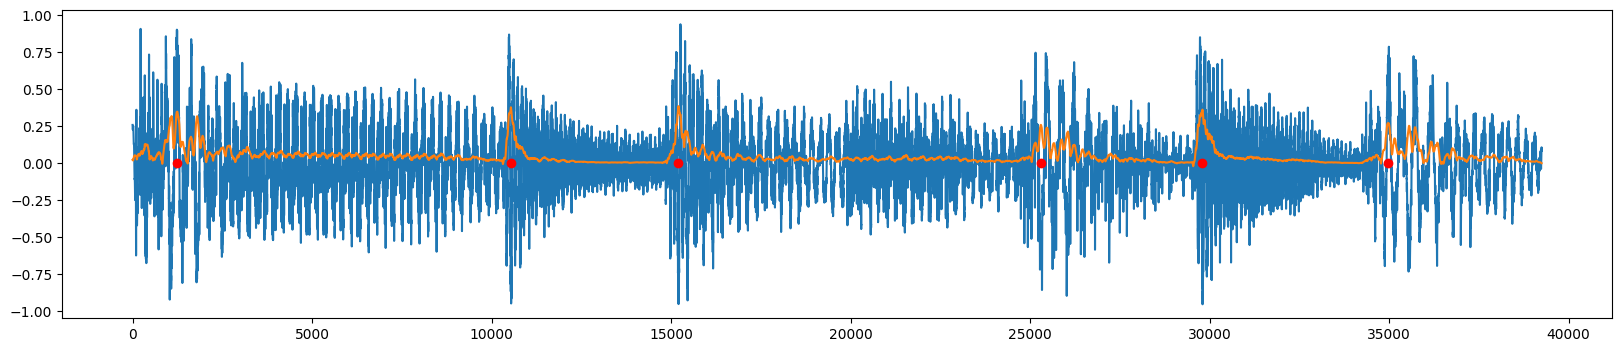

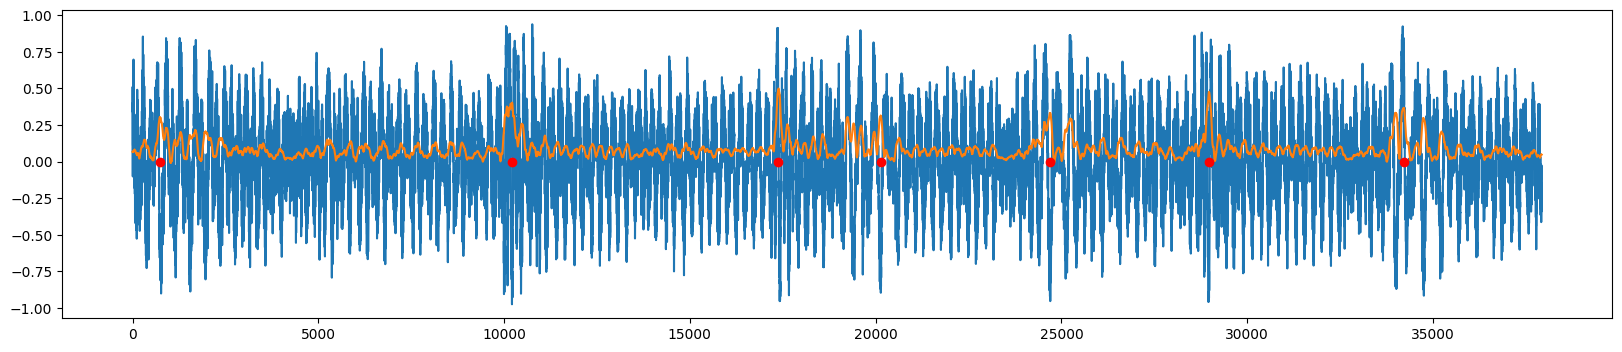

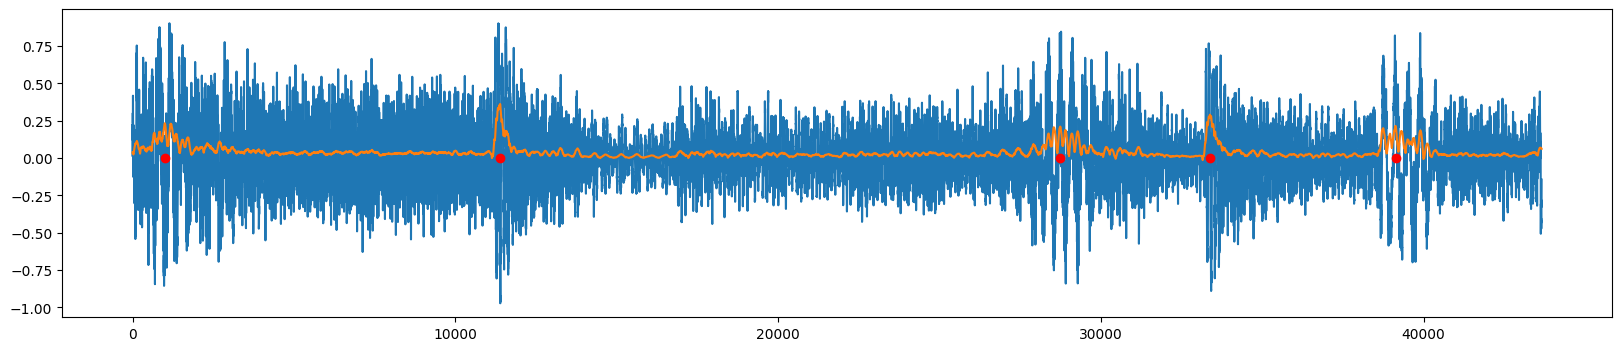

In [28]:
from IPython.display import Audio
from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks
import librosa

def find_closest_indices(means, data):
    outs = []
    for i in range(means.shape[0]):
        distances = np.linalg.norm(means[i] - data, axis=1)
        outs.append(distances.argmin(keepdims=True)[0])
    return np.stack(outs)

print(gm.means_.shape, data.shape)

inds = find_closest_indices(gm.means_, data)
data[inds]
print(inds)

inds = np.append(inds, np.array([0, 23, 125]))

raw_measures, proc_measures, sr = get_measures(file, smooth_power)
for i in inds:
    raw, proc = raw_measures[i], proc_measures[i]
    beat_frames = get_beat_frames([proc], sr, beat_peaks)[0][0]
    clicks = librosa.clicks(times=beat_frames/sr, length=raw.shape[0], sr=sr)


    plt.figure(figsize=(20, 4))
    plt.plot(raw)
    plt.plot(proc)
    plt.scatter(beat_frames, np.zeros(beat_frames.shape), marker='o', color='red', zorder=10)
    #display(Audio(data=raw, rate=sr))
    display(Audio(data=raw + clicks, rate=sr))


In [29]:
print(gm.means_[0] - gm.means_[2])
print(np.linalg.norm(gm.covariances_[0]))

[-6.89915141e-03 -3.50655726e-04  8.76639316e-06  1.16067045e-02
  4.73385230e-03  3.87474577e-03 -6.88161863e-03  2.57731959e-03
  8.59106529e-04 -3.63805316e-03  2.27663230e-02  8.59106529e-03
  3.26986465e-02  4.73385230e-03 -4.20786871e-04 -9.91479066e-03
  7.80208991e-03  5.16340557e-03 -6.88161863e-03  2.62991795e-05
  3.00687285e-03 -4.29553265e-03  3.03317203e-03  8.59106529e-04
 -8.59106529e-03  2.32309419e-02  1.54989831e-02 -1.11859177e-02
 -5.55789326e-03  6.09965636e-02  6.97103584e-02 -1.89704748e-02
  2.16354583e-02 -1.20450242e-02 -5.15463918e-03  6.92545059e-03
 -1.28865979e-02  4.51556911e-02 -1.54902167e-02  5.22301704e-02
  1.02014517e-01 -1.67525773e-02 -1.54902167e-02 -2.57731959e-03
 -3.43642612e-03 -1.71821306e-02  6.96402272e-02  6.80272109e-03
 -1.54639175e-02 -3.60822483e-16 -5.15463918e-03 -2.57731959e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
0.013980300614386546


My dumb toy embedding magnifies small differences.

In [30]:
print((data[inds[0]] - data[inds[2]])[:24])
print((data[inds[0]] - data[inds[2]])[24:24+12])
print((data[inds[0]] - data[inds[2]])[24+12:24+12+8])
print((data[inds[0]] - data[inds[2]])[24+12+8:24+12+8+4])
print((data[inds[0]] - data[inds[2]])[24+12+8+4:24+12+8+4+2])

u = data[inds[0]] - data[inds[2]]
print(np.linalg.norm(u))
print(u)

print((data[inds[0]] - data[inds[1]]))
print((data[inds[0]] - data[inds[1]])[:24])
print(np.linalg.norm(data[inds[0]] - data[inds[1]]))


get_beat_frames([proc_measures[79], proc_measures[23]], sr, beat_peaks)

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.04166667  0.04166667  0.
  0.04166667  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
[ 0.          0.          0.          0.         -0.08333333  0.08333333
  0.08333333  0.          0.          0.          0.          0.        ]
[0.    0.    0.    0.    0.125 0.    0.    0.   ]
[0. 0. 0. 0.]
[0. 0.]
0.2041241452319315
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.04166667  0.04166667  0.
  0.04166667  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.08333333  0.08333333
  0.08333333  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.125       0.
  0.          0.          0.  

([array([  667,  9935, 17165, 19980, 25304, 28925, 33625]),
  array([  738, 10217, 17385, 20138, 24690, 28971, 34209])],
 [37926, 37926])

In [31]:
print((data[inds[0]] - data[inds[1]])[:24])
print((data[inds[0]] - data[inds[1]])[24:24+12])
print((data[inds[0]] - data[inds[1]])[24+12:24+12+8])
print((data[inds[0]] - data[inds[1]])[24+12+8:24+12+8+4])
print((data[inds[0]] - data[inds[1]])[24+12+8+4:24+12+8+4+2])


[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.04166667 0.         0.        ]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.08333333 0.        ]
[0.    0.    0.    0.    0.    0.    0.    0.125]
[0. 0. 0. 0.]
[0.         0.16666667]
